# Extract and load data

**Concatenate all the files to make easier the extraction**

In [169]:
#find data -type f -name "*.txt" -exec cat {} + > all_data.txt

## Extract locations and store them into a file

In [170]:
import json
import pandas as pd

with open('../data/all_data.txt', 'r', encoding='latin-1') as file:
    lines = file.readlines()

latitudes = []
longitudes = []
altitudes = []
accuracies = []

for idx, line in enumerate(lines):
    try:
        data = json.loads(line)
        if not isinstance(data, dict):
            continue
    except Exception as e:
        continue

    if 'Location' in data:
        data_location = data['Location']
        latitudes.append(data_location['Latitude'])
        longitudes.append(data_location['Longtitude'])
        altitudes.append(data_location['Altitude'])
        accuracies.append(data_location['Accuracy'])

KeyboardInterrupt: 

In [ ]:
df_locations = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes, "Altitude": altitudes, "Accuracy": accuracies})
# df_locations = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes, "Accuracy": accuracies})

df_locations.drop_duplicates(inplace=True)

df_locations.to_csv("../data/locations.csv", index=False)

## Load data from the .csv file

In [173]:
import pandas as pd
df_locations = pd.read_csv("../data/locations.csv")

df_locations['Altitude'] = df_locations['Altitude'].apply(lambda x: x/1000)
# df_locations['Latitude'] = df_locations['Latitude'].apply(lambda x: x*10)


# Clustering

In [171]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm


# Define the range of cluster numbers to try
min_clusters = 12
max_clusters = 18

# Initialize variables to store the best number of clusters and the corresponding silhouette score
best_num_clusters = 0
best_silhouette_score = -1
silhouette_scores = []

df_sampled = df_locations.drop('Accuracy', axis=1).sample(50000,random_state=52)
# Iterate over the range of cluster numbers
for num_clusters in range(min_clusters, max_clusters + 1):
    # Perform clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_sampled)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(df_sampled, kmeans.labels_)
    print("Silhouette score:", silhouette_avg, "with", num_clusters, "clusters")
    silhouette_scores.append(silhouette_avg)
    
    # Check if the current silhouette score is better than the previous best score
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_num_clusters = num_clusters

# Print the best number of clusters and the corresponding silhouette score
print("Best number of clusters:", best_num_clusters)
print("Silhouette score:", best_silhouette_score)


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

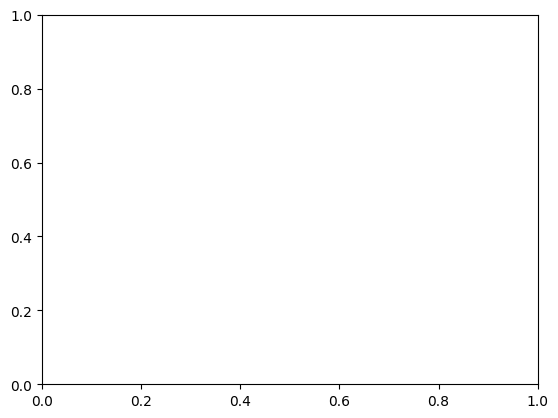

In [172]:
#plot silhoutte graph
import matplotlib.pyplot as plt

plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs Number of clusters')
plt.show()


In [174]:
kmeans = KMeans(n_clusters=13,random_state=42)

kmeans.fit(df_locations.drop('Accuracy', axis=1))
df_locations['Cluster'] = kmeans.predict(df_locations.drop('Accuracy', axis=1))

In [175]:
df_locations["Cluster"].value_counts()

Cluster
12    219831
0     169731
1      68930
4      24483
6      14616
3      14177
10      2866
7        824
2        573
5        528
9         42
11         7
8          5
Name: count, dtype: int64

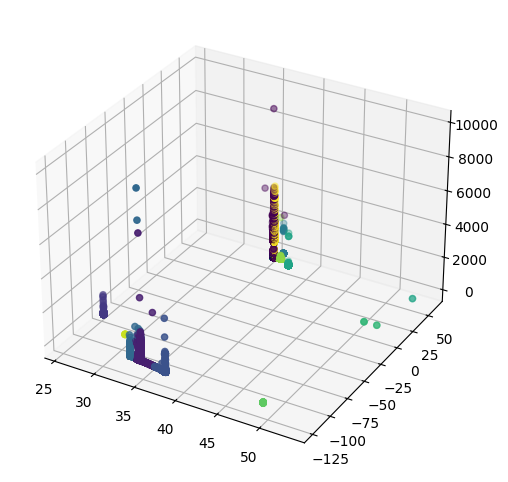

In [176]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_locations['Latitude'], df_locations['Longitude'],df_locations['Accuracy'], c=df_locations['Cluster'])
plt.show()

/var/folders/x5/spm_6r5944dfgx3qj8my0m440000gn/T/ipykernel_1184/2034884922.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


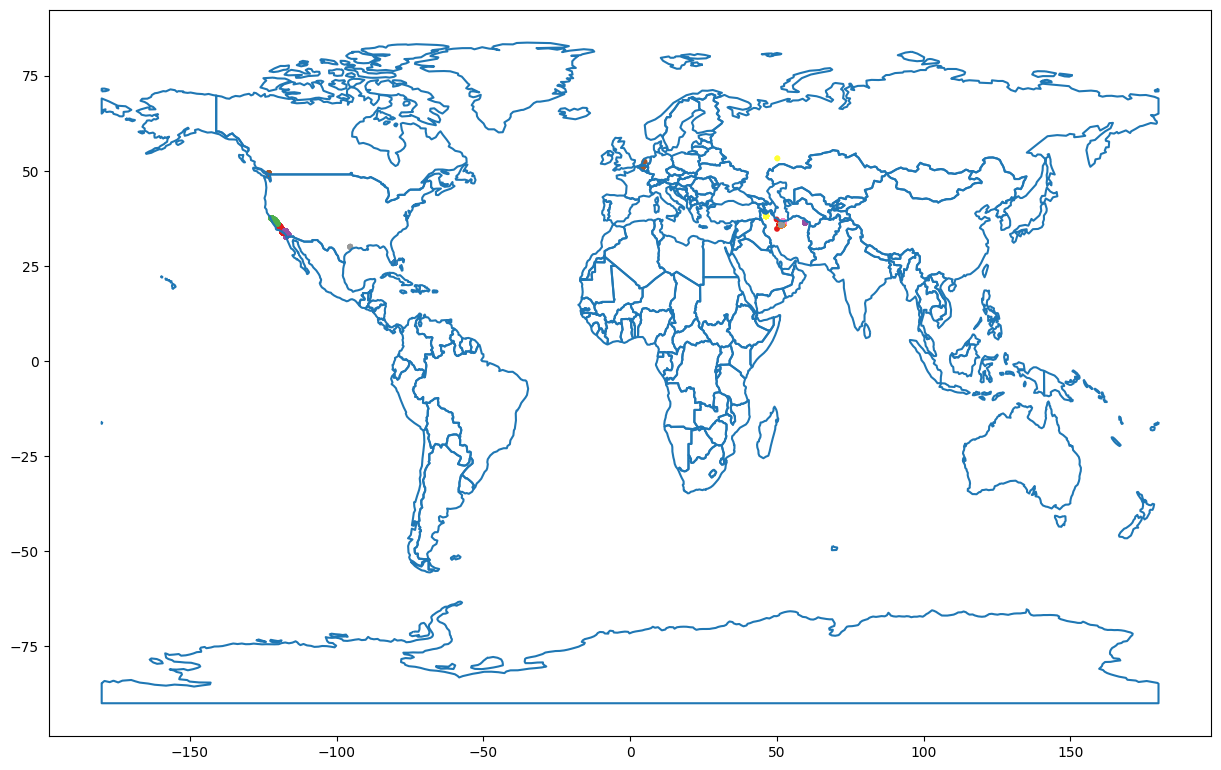

In [177]:
import geopandas as gpd
from shapely.geometry import Point

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry = [Point(xy) for xy in zip(df_locations['Longitude'], df_locations['Latitude'])]
gdf = gpd.GeoDataFrame(df_locations, geometry=geometry)
gdf.crs = world.crs

fig, ax = plt.subplots(figsize=(15, 15))
world.boundary.plot(ax=ax)
gdf.plot(ax=ax, column=df_locations["Cluster"], cmap='Set1', markersize=10)
plt.show()

/var/folders/x5/spm_6r5944dfgx3qj8my0m440000gn/T/ipykernel_1184/917907154.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


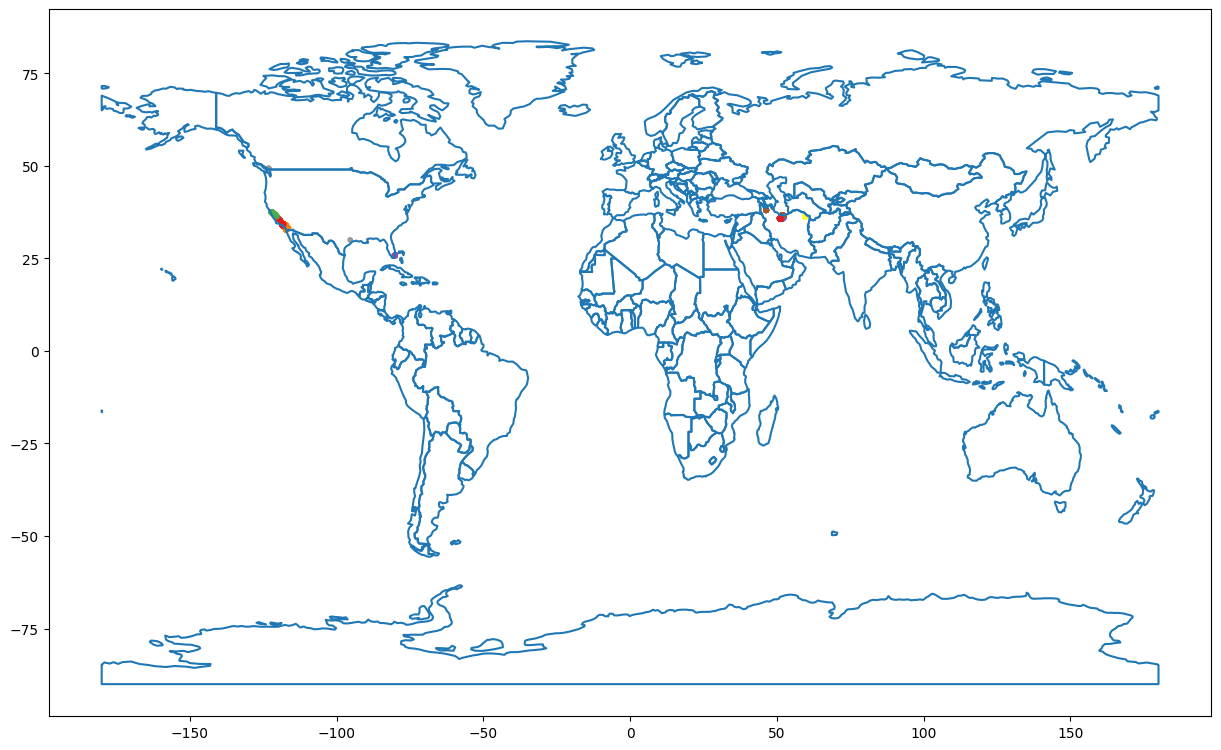

In [178]:
import geopandas as gpd
from shapely.geometry import Point

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry = [Point(xy) for xy in zip(df_sampled['Longitude'], df_sampled['Latitude'])]
gdf = gpd.GeoDataFrame(df_sampled, geometry=geometry)
gdf.crs = world.crs

fig, ax = plt.subplots(figsize=(15, 15))
world.boundary.plot(ax=ax)
gdf.plot(ax=ax, column=df_sampled["Cluster"], cmap='Set1', markersize=10)
plt.show()

## Reducción de dimensiones

In [179]:
df_locations

,Latitude,Longitude,Altitude,Accuracy,Cluster
0,35.709760,51.316011,0.0,27.000,0
1,35.709759,51.316007,0.0,25.000,0
2,35.709759,51.316007,0.0,29.000,0
3,35.709781,51.315990,0.0,25.000,0
4,35.709760,51.316007,0.0,25.000,0
...,...,...,...,...,...
516608,35.782574,51.360892,0.0,86.773,12
516609,35.782570,51.360880,0.0,86.420,12
516610,35.782560,51.360820,0.0,85.538,12
516611,35.782544,51.360890,0.0,217.383,12


In [180]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,whiten=False).fit(df_locations.drop('Accuracy', axis=1).drop('Cluster', axis=1))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
reducted = pca.fit_transform(df_locations.drop('Accuracy', axis=1).drop('Cluster', axis=1))
reductedDf = pd.DataFrame(reducted, columns=['PC1', 'PC2'])

[9.99901131e-01 8.68466712e-05]
[49615.73255786   462.39961809]


In [181]:
reductedDf['Cluster'] = df_locations['Cluster']

In [182]:
reductedDf

,PC1,PC2,Cluster
0,-35.445250,-0.043057,0
1,-35.445247,-0.043058,0
2,-35.445247,-0.043058,0
3,-35.445230,-0.043036,0
4,-35.445247,-0.043057,0
...,...,...,...
516608,-35.490664,0.029419,12
516609,-35.490651,0.029416,12
516610,-35.490592,0.029406,12
516611,-35.490661,0.029390,12


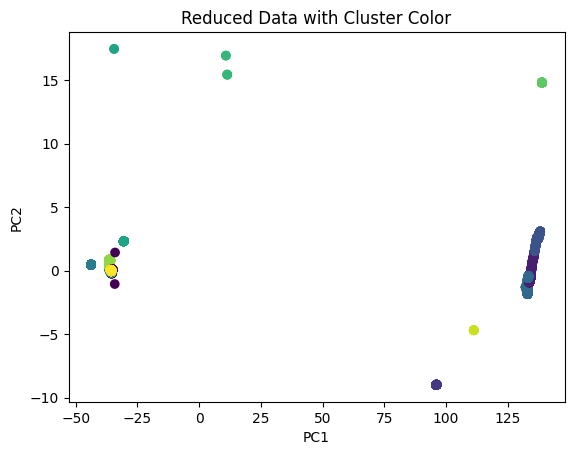

In [183]:
import matplotlib.pyplot as plt

plt.scatter(reductedDf['PC1'],reductedDf['PC2'], c=reductedDf['Cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Reduced Data with Cluster Color')
plt.show()


In [184]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1,whiten=False).fit(df_locations.drop('Accuracy', axis=1).drop('Cluster', axis=1))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
reducted = pca.fit_transform(df_locations.drop('Accuracy', axis=1).drop('Cluster', axis=1))
reductedDf = pd.DataFrame(reducted, columns=['PC1'])

[0.99990113]
[49615.73255786]


In [185]:
reductedDf['Cluster'] = df_locations['Cluster']

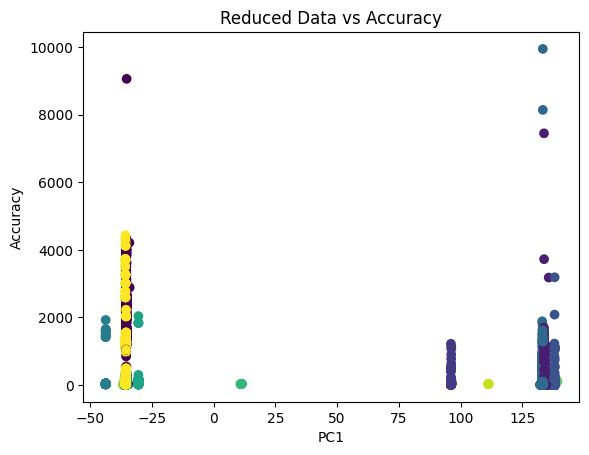

In [187]:

import matplotlib.pyplot as plt

plt.scatter(reductedDf['PC1'],df_locations['Accuracy'], c=reductedDf['Cluster'])
plt.xlabel('PC1')
plt.ylabel('Accuracy')
plt.title('Reduced Data vs Accuracy')
plt.show()
